## 1. Import Data

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

%matplotlib inline


df = pd.read_csv('hw3.csv')


## 2. Understanding Data

In [2]:
# Understand the columns

df.head()


,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
# check for NAN's presence in each field
pd.isnull(df).sum()

ts              0
open            0
high          504
low           289
close         136
volume          0
volumeUSD    2667
token           0
chain           0
dtype: int64

In [4]:
field = ["open", "high", "low", "close", "volume", "volumeUSD"]

#for i in df.columns.values.tolist():
for i in field:
    print("Number of NaN in " + i + " is " + str(df[i].isna().sum()))

Number of NaN in open is 0
Number of NaN in high is 504
Number of NaN in low is 289
Number of NaN in close is 136
Number of NaN in volume is 0
Number of NaN in volumeUSD is 2667


In [5]:
# check for inf's presence in each field

for i in field:
    print("Number of Inf in " + i + " is " + str(np.isinf(df[i]).sum()))

Number of Inf in open is 0
Number of Inf in high is 0
Number of Inf in low is 0
Number of Inf in close is 0
Number of Inf in volume is 0
Number of Inf in volumeUSD is 0


From above, we know that the "Volume" colume is fully filled but there are empty cells in "close"

To determine volumeUSD = volume * close, we need to estimate the empty cells in "close" 

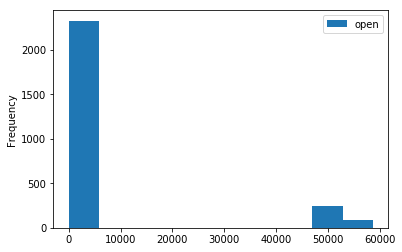

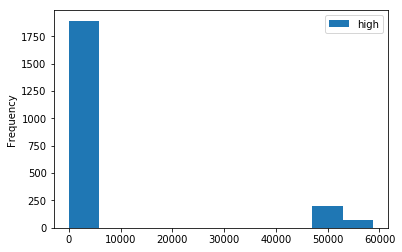

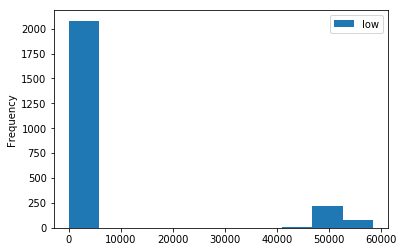

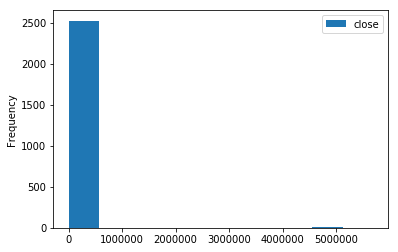

In [6]:
#Plot the histogram to understand the entries of each field

df[['open']].plot(kind='hist')
df[['high']].plot(kind='hist')
df[['low']].plot(kind='hist')
df[['close']].plot(kind='hist')




From here it does not seem to have out of place values (such as negative ones)

In [7]:
# Check for duplicate values
np.count_nonzero(df.duplicated(subset=['ts', 'token']))


307

With these we need to remove the duplicates before continuing

In [8]:
# Check for strange entries in the categorical variables
df['token'].unique()

array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC',
       '<span name="tokenName">UNI</span>',
       '<span name="tokenName">CRV</span>',
       '<span name="tokenName">SOL</span>',
       '<span name="tokenName">USDT</span>',
       '<span name="tokenName">COMP</span>',
       '<span name="tokenName">AAVE</span>',
       '<span name="tokenName">ETH</span>',
       '<span name="tokenName">BTC</span>'], dtype=object)

In [9]:
df['chain'].unique()

array(['ETH', 'SOL', 'USDT', 'BTC'], dtype=object)

Here we can see that "token" has some long entries that could be converted to standard token names
But for "chain" name, it is all unique.

## 3. Cleaning the data

Firstly we need to clean the strange long names in "token"

In [10]:
# firstly delimit and split out the 'token' column
df_sup = df.token.str[23:]
df_sup = df_sup.str.split('<', expand=True)
#df_sup = df.token.str.extract('<span name="tokenName">(.|\n)*?</span>')


#now df_sup contains the entries that we want to correct in df["token"]

df_cleaned=df

for i in range(df.shape[0]):
    if df_sup[0][i] == "":
        pass
    else: 
        df_cleaned["token"][i]=df_sup[0][i]

   
#check that the "token" column now is ok
df_cleaned['token'].unique()
        
        

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python36_64\Lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC'],
      dtype=object)

Looks okay now.

Next step, we try to remove all the duplicates

In [11]:
# clean the duplicated values

df_cleaned = df_cleaned.drop_duplicates(subset=['ts', 'token'], keep='first')
#df_cleaned

Next, we try to estimate the close price using the same period's "open", "high", "low"
Assuming that "close" is the average of these 3 columns

In [12]:
# avg of open high low prices assigned to column close when it is NaN
close_cleaned = pd.DataFrame(np.where(np.isnan(df_cleaned["close"]), 
                                      (np.where(np.isnan(df_cleaned["open"]),0,df_cleaned["open"])
                                      +np.where(np.isnan(df_cleaned["high"]),0,df_cleaned["high"])
                                      +np.where(np.isnan(df_cleaned["low"]),0,df_cleaned["low"]))/
                                      (np.where(np.isnan(df_cleaned["open"]),0,1)
                                      +np.where(np.isnan(df_cleaned["high"]),0,1)
                                      +np.where(np.isnan(df_cleaned["low"]),0,1)), df_cleaned["close"]),columns=['close_cleaned'])
close_cleaned_index = pd.DataFrame(df_cleaned.index, columns=['close_cleaned_index'])
close_cleaned = pd.concat([close_cleaned, close_cleaned_index], axis=1)
close_cleaned = close_cleaned.set_index('close_cleaned_index')
df_cleaned = pd.concat([df_cleaned, close_cleaned], axis=1)
#df_cleaned


Finally the summary of Volume USD by different chain

In [13]:
df_cleaned["volumeUSD"] = df_cleaned["volume"]*df_cleaned["close_cleaned"]

df_USDvolume = df_cleaned.groupby('chain')['volumeUSD'].sum().to_frame()
#df_cleaned
df_USDvolume


,volumeUSD
chain,
BTC,3.859544e+10
ETH,1.737819e+10
SOL,6.907850e+09
USDT,1.519147e+09
